# Lab: Single-Molecule Kinetics — PKA–ATP Binding

In this lab, we will walk through the process of:
1. Loading and visualizing real single-molecule experimental data from a carbon nanotube sensor.
2. Building a **current histogram** and fitting it with a **double-Gaussian** model to test whether binding is a single-step or multi-step process.
3. Extracting **dwell times** from pre-detected switching events and computing first-order **rate constants**.
4. Connecting microscopic kinetics to macroscopic **thermodynamics** ($K_\text{eq}$, $\Delta G$).

*Data source: Coroneus et al., PKA–ATP binding measured via carbon nanotube field-effect transistor.*

In [1]:
# Run this cell to import important packages for this lab
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit

---
## 1. Introduction

In a typical chemistry experiment, you measure the behaviour of *trillions* of molecules at once — an **ensemble** measurement. The result is an average: you learn the mean binding rate, but not what any individual molecule is doing.

In this lab, we analyse data from a **single-molecule** experiment. A single Protein Kinase A (PKA) enzyme is attached to a carbon nanotube transistor. When an ATP molecule binds to PKA, the device current jumps up; when ATP unbinds, the current drops back down. We can watch these events one at a time.

```
              ATP binds                ATP unbinds
  State 0 ──────────────▶ State 1 ──────────────▶ State 0
  (low I)     k₀ (s⁻¹)    (high I)    k₁ (s⁻¹)    (low I)
```

| Symbol | Meaning |
|---|---|
| $I_0$ (State 0) | PKA alone — ATP **unbound** (low current) |
| $I_1$ (State 1) | PKA·ATP complex — ATP **bound** (high current) |
| $k_0$ | Rate constant for leaving State 0 (binding) |
| $k_1$ | Rate constant for leaving State 1 (unbinding) |

Our data file covers a **2-second window** (153–155 s) sampled at **100 kHz** — that's 200,000 current measurements. The data has been lightly smoothed (20-point moving average), so we can jump straight into analysis.

**Question**: Why might watching a *single* molecule reveal information that an ensemble measurement cannot? Think about what happens when you average over trillions of molecules.

*Type your answer here, replacing this text.*

---
## 2. Loading the Data

Our data is stored in a TDMS file (a LabVIEW format). We use the `nptdms` library to read it. The file contains three channels:

- **CleanSwitch** — the smoothed current trace (200,000 samples)
- **EventState** — pre-detected state labels (0 or 1 for each event)
- **EventDuration** — duration of each event in samples

Run the following cell to load the data.

In [2]:
# Run this cell
from nptdms import TdmsFile

DATA_PATH = "Data/Time 153 to 155s State 2 Smooth 20 Supp 15.tdms"
tdms = TdmsFile.read(DATA_PATH)

# Show file structure
for group in tdms.groups():
    print(f"Group: '{group.name}'")
    for ch in group.channels():
        print(f"  Channel: '{ch.name}'  —  {len(ch)} samples")
        for prop in ch.properties:
            print(f"    {prop}: {ch.properties[prop]}")

Group: 'Switching analysis'
  Channel: 'CleanSwitch'  —  200000 samples
    wf_start_time: 1904-01-01T00:00:00.000000
    wf_start_offset: 0.0
    wf_increment: 9.999999999999972e-06
    wf_samples: 100000
    NI_ChannelName: CleanSwitch
  Channel: 'EventState'  —  100 samples
    wf_start_time: 1904-01-01T00:00:00.000000
    wf_start_offset: 0.0
    wf_increment: 1.0
    wf_samples: 66
    NI_ChannelName: EventState
  Channel: 'EventDuration'  —  100 samples
    wf_start_time: 1904-01-01T00:00:00.000000
    wf_start_offset: 0.0
    wf_increment: 1.0
    wf_samples: 66
    NI_ChannelName: EventDuration


Now let's extract the three channels and convert to convenient units.

In [3]:
# Run this cell
group = tdms["Switching analysis"]

current_raw   = group["CleanSwitch"][:]     # Current trace in Amps
event_state   = group["EventState"][:]      # 0 or 1 per event
event_dur     = group["EventDuration"][:]   # Duration in samples

# Physical parameters
sampling_rate = 100_000                     # 100 kHz
dt = 1.0 / sampling_rate                   # 10 µs per sample

# Convert current to nanoamps for readability
current_nA = current_raw * 1e9

# Time axis in milliseconds
time_ms = np.arange(len(current_nA)) * dt * 1000

# Valid events (first 66 per metadata)
n_events = 66
states    = event_state[:n_events].astype(int)
durations = event_dur[:n_events]

print(f"Current trace : {len(current_nA):,} samples  ({time_ms[-1]/1000:.1f} s)")
print(f"Current range : {current_nA.min():.2f} – {current_nA.max():.2f} nA")
print(f"Valid events  : {n_events}")
print(f"  State 0 events: {np.sum(states == 0)}")
print(f"  State 1 events: {np.sum(states == 1)}")

Current trace : 200,000 samples  (2.0 s)
Current range : 34.15 – 42.74 nA
Valid events  : 66
  State 0 events: 33
  State 1 events: 33


**Question**: The current trace has 200,000 samples covering 2 seconds. What is the time resolution (time between consecutive samples)? Why might such high time resolution be necessary for this experiment?

*Type your answer here, replacing this text.*

---
## 3. Visualizing the Switching Trace

Before doing any analysis, let's *look* at the data. We'll plot the current trace at three different zoom levels.

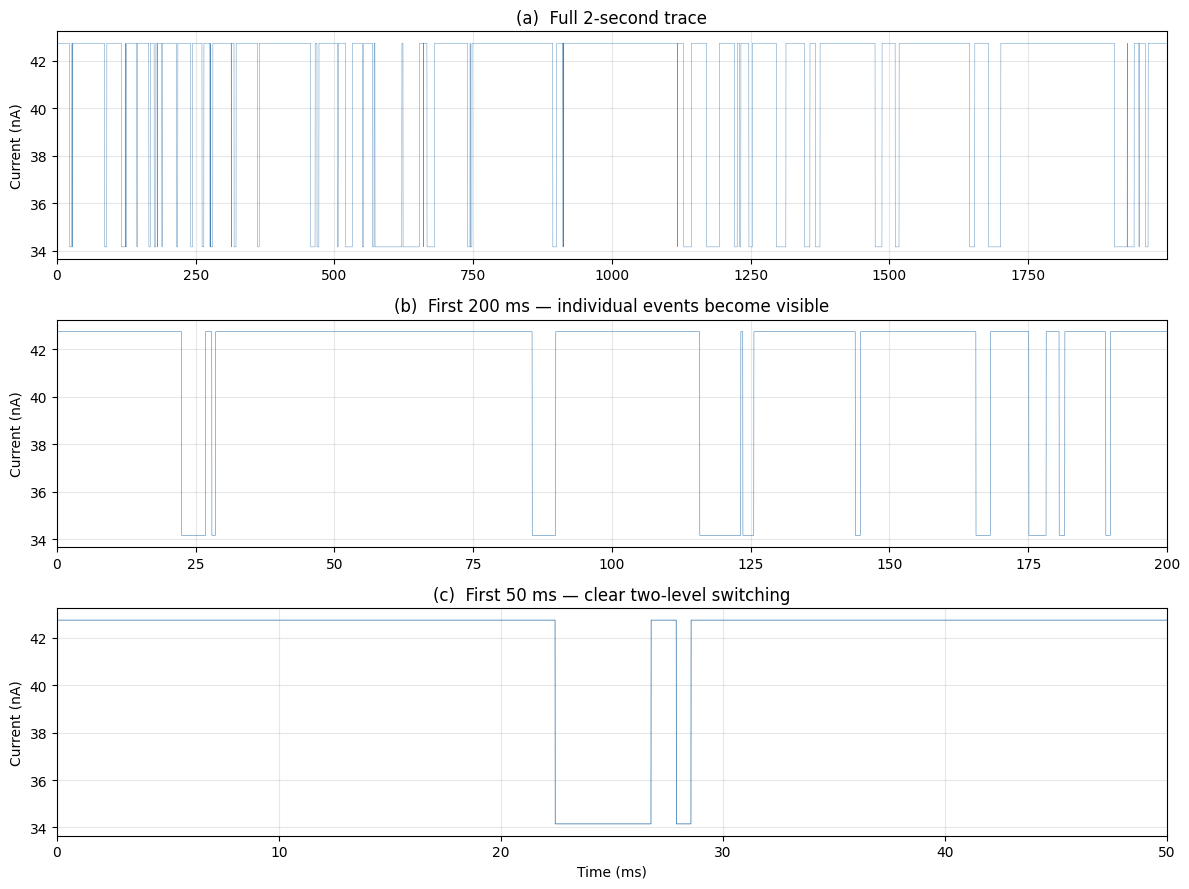

In [4]:
# Run this cell
fig, axes = plt.subplots(3, 1, figsize=(12, 9))

# (a) Full 2-second trace
axes[0].plot(time_ms, current_nA, lw=0.3, color='steelblue')
axes[0].set_title("(a)  Full 2-second trace")
axes[0].set_ylabel("Current (nA)")
axes[0].set_xlim(time_ms[0], time_ms[-1])

# (b) First 200 ms
mask_b = time_ms <= 200
axes[1].plot(time_ms[mask_b], current_nA[mask_b], lw=0.4, color='steelblue')
axes[1].set_title("(b)  First 200 ms — individual events become visible")
axes[1].set_ylabel("Current (nA)")
axes[1].set_xlim(0, 200)

# (c) First 50 ms
mask_c = time_ms <= 50
axes[2].plot(time_ms[mask_c], current_nA[mask_c], lw=0.6, color='steelblue')
axes[2].set_title("(c)  First 50 ms — clear two-level switching")
axes[2].set_ylabel("Current (nA)")
axes[2].set_xlabel("Time (ms)")
axes[2].set_xlim(0, 50)

for ax in axes:
    ax.set_ylim(current_nA.min() - 0.5, current_nA.max() + 0.5)
    ax.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

**Question**: Describe what you see. How many distinct current levels are there? Do the switching events appear periodic (regular) or random? What does this tell you about the underlying process?

*Type your answer here, replacing this text.*

---
## 4. Current Distribution and the Gaussian Test

This is the central analysis of the lab. We will:

1. Histogram every current sample in the 2-second trace.
2. Fit the distribution with a **double Gaussian**.
3. Extract the width $\sigma$ of each peak.

### Why does this matter?

The current fluctuates around each level because of **thermal noise** — random jostling of atoms and electrons at room temperature. Statistical mechanics (via the **Central Limit Theorem**) tells us that if the molecular process is a **single-step** reaction, these thermal fluctuations produce a **Gaussian** distribution:

$$I \sim \mathcal{N}(\mu,\,\sigma^2)$$

If instead there are **hidden intermediate states** (a multi-step process), the distribution deviates from Gaussian — it becomes broader, skewed, or develops shoulders.

> **The Gaussian test:** Narrow, symmetric Gaussians → single-step process. Non-Gaussian tails → evidence for hidden intermediate steps.

The PKA–ATP system has already been characterised as single-step, so we expect clean Gaussians. Let's verify.

### 4a. Building the Histogram

Run the cell below to build a histogram of all 200,000 current values.

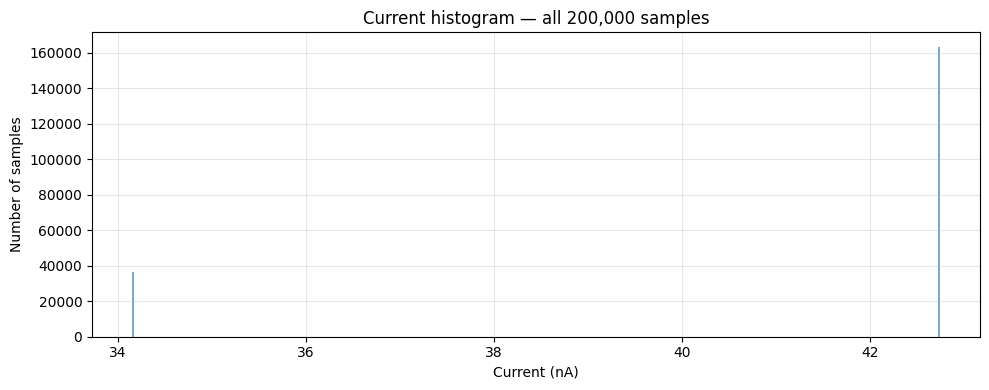

In [5]:
# Run this cell
n_bins = 400
counts, bin_edges = np.histogram(current_nA, bins=n_bins)
bin_centres = 0.5 * (bin_edges[:-1] + bin_edges[1:])

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(bin_centres, counts, width=np.diff(bin_edges)[0],
       color='steelblue', alpha=0.7, edgecolor='none')
ax.set_xlabel("Current (nA)")
ax.set_ylabel("Number of samples")
ax.set_title("Current histogram — all 200,000 samples")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

You should see **two sharp peaks** — one for each conductance state. Because the data was smoothed (20-point filter), the noise around each level is very small, making the peaks appear as narrow spikes. The Gaussian shape becomes visible when we zoom in.

### 4b. Fitting the Double Gaussian

We model the histogram as the sum of two Gaussians:

$$f(I) = A_0 \exp\!\left(-\frac{(I - \mu_0)^2}{2\sigma_0^2}\right) + A_1 \exp\!\left(-\frac{(I - \mu_1)^2}{2\sigma_1^2}\right)$$

where $\mu_0, \mu_1$ are the peak centres, $\sigma_0, \sigma_1$ are the widths, and $A_0, A_1$ are the amplitudes.

In [6]:
# Run this cell — define the model and estimate initial parameters

def gaussian(x, A, mu, sigma):
    """Single Gaussian peak."""
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2)

def double_gaussian(x, A0, mu0, sigma0, A1, mu1, sigma1):
    """Sum of two Gaussians."""
    return gaussian(x, A0, mu0, sigma0) + gaussian(x, A1, mu1, sigma1)

# --- Initial parameter estimates ---
# Split data at the midpoint and find the mode of each half.
I_mid = (current_nA.min() + current_nA.max()) / 2.0
samples_lo = current_nA[current_nA < I_mid]
samples_hi = current_nA[current_nA >= I_mid]

# Peak centres from sub-histograms
counts_lo, edges_lo = np.histogram(samples_lo, bins=100)
centres_lo = 0.5 * (edges_lo[:-1] + edges_lo[1:])
mu0_est = centres_lo[np.argmax(counts_lo)]

counts_hi, edges_hi = np.histogram(samples_hi, bins=100)
centres_hi = 0.5 * (edges_hi[:-1] + edges_hi[1:])
mu1_est = centres_hi[np.argmax(counts_hi)]

# Peak amplitudes from main histogram
A0_est = counts[np.argmin(np.abs(bin_centres - mu0_est))]
A1_est = counts[np.argmin(np.abs(bin_centres - mu1_est))]

# Sigma from samples near each peak
near0 = samples_lo[np.abs(samples_lo - mu0_est) < 1.0]
near1 = samples_hi[np.abs(samples_hi - mu1_est) < 1.0]
sig0_est = max(np.std(near0) if len(near0) > 10 else 0.1, 0.01)
sig1_est = max(np.std(near1) if len(near1) > 10 else 0.1, 0.01)

p0 = [A0_est, mu0_est, sig0_est, A1_est, mu1_est, sig1_est]

print("Initial estimates:")
print(f"  State 0:  A₀ = {A0_est:.0f},  μ₀ = {mu0_est:.2f} nA,  σ₀ = {sig0_est:.4f} nA")
print(f"  State 1:  A₁ = {A1_est:.0f},  μ₁ = {mu1_est:.2f} nA,  σ₁ = {sig1_est:.4f} nA")

Initial estimates:
  State 0:  A₀ = 36524,  μ₀ = 34.16 nA,  σ₀ = 0.0100 nA
  State 1:  A₁ = 163476,  μ₁ = 42.75 nA,  σ₁ = 0.0100 nA


In [7]:
# Run this cell — perform the fit
bounds_lo = [0, mu0_est - 2, 0.001, 0, mu1_est - 2, 0.001]
bounds_hi = [np.inf, mu0_est + 2, 5.0, np.inf, mu1_est + 2, 5.0]

# Ensure starting values are within bounds
p0[2] = np.clip(p0[2], 0.002, 4.9)
p0[5] = np.clip(p0[5], 0.002, 4.9)

popt, pcov = curve_fit(double_gaussian, bin_centres, counts,
                       p0=p0, bounds=(bounds_lo, bounds_hi), maxfev=20000)

A0, mu0, sigma0, A1, mu1, sigma1 = popt
perr = np.sqrt(np.diag(pcov))

print("=" * 50)
print("     DOUBLE-GAUSSIAN FIT RESULTS")
print("=" * 50)
print(f"  State 0 (ATP unbound)")
print(f"    μ₀  = {mu0:.3f} ± {perr[1]:.4f} nA")
print(f"    σ₀  = {sigma0:.4f} ± {perr[2]:.4f} nA  ◀ Gaussian width")
print(f"    A₀  = {A0:.0f}")
print()
print(f"  State 1 (ATP bound)")
print(f"    μ₁  = {mu1:.3f} ± {perr[4]:.4f} nA")
print(f"    σ₁  = {sigma1:.4f} ± {perr[5]:.4f} nA  ◀ Gaussian width")
print(f"    A₁  = {A1:.0f}")
print()
print(f"  Current separation: Δμ = {abs(mu1 - mu0):.2f} nA")
print(f"  Signal-to-noise: Δμ / (σ₀ + σ₁) = {abs(mu1-mu0)/(sigma0+sigma1):.1f}")
print("=" * 50)

     DOUBLE-GAUSSIAN FIT RESULTS
  State 0 (ATP unbound)
    μ₀  = 34.161 ± 0.0054 nA
    σ₀  = 0.0038 ± 0.0073 nA  ◀ Gaussian width
    A₀  = 48026

  State 1 (ATP bound)
    μ₁  = 42.736 ± 0.0000 nA
    σ₁  = 0.0050 ± 0.0000 nA  ◀ Gaussian width
    A₁  = 379735

  Current separation: Δμ = 8.57 nA
  Signal-to-noise: Δμ / (σ₀ + σ₁) = 974.6


### 4c. Visualizing the Fit

The full-range histogram shows two sharp spikes because the smoothed data has very little noise. To see the actual Gaussian bell-curve shapes, the inset panels zoom in on each peak individually (cf. Figure 2b/2c insets in the original paper).

/var/folders/wm/t8qsrrmn583g_f2mxd1drrh1kl92z7/T/ipykernel_60012/3884425711.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


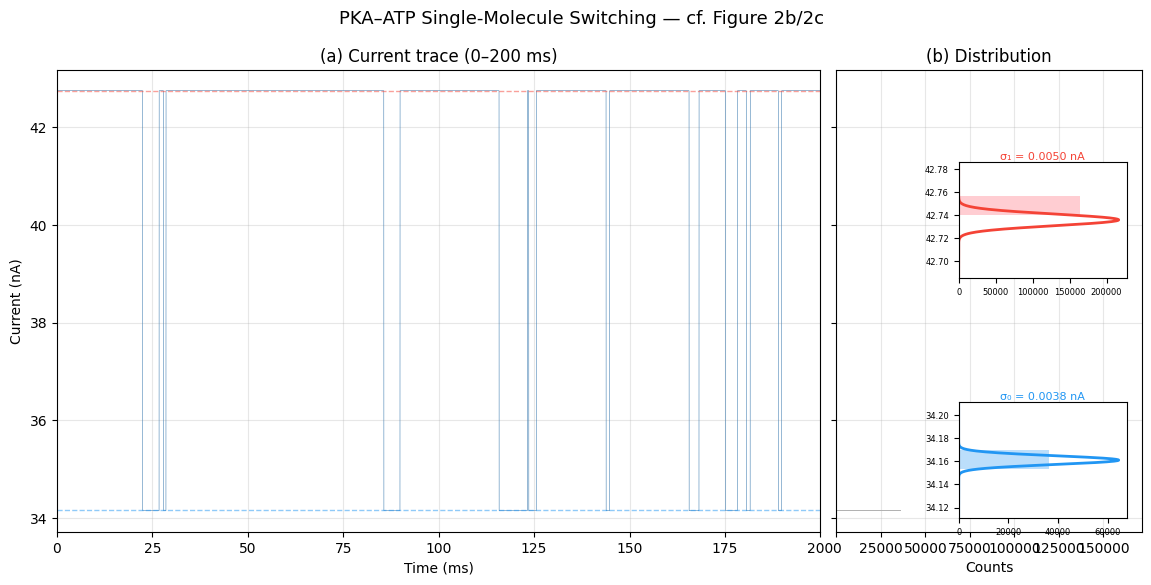

In [8]:
# Run this cell — paper-style figure with inset zoom panels
fig, (ax_trace, ax_hist) = plt.subplots(
    1, 2, figsize=(14, 6), sharey=True,
    gridspec_kw={'width_ratios': [3, 1.2], 'wspace': 0.03}
)

# --- Left: time trace ---
mask_zoom = time_ms <= 200
ax_trace.plot(time_ms[mask_zoom], current_nA[mask_zoom], lw=0.4, color='steelblue')
ax_trace.axhline(mu0, color='#2196F3', ls='--', lw=1, alpha=0.5)
ax_trace.axhline(mu1, color='#F44336', ls='--', lw=1, alpha=0.5)
ax_trace.set_xlabel("Time (ms)")
ax_trace.set_ylabel("Current (nA)")
ax_trace.set_title("(a) Current trace (0–200 ms)")
ax_trace.set_xlim(0, 200)
ax_trace.grid(True, alpha=0.3)

# --- Right: sideways histogram (full range) ---
n_fine = 800
counts_fine, edges_fine = np.histogram(current_nA, bins=n_fine)
centres_fine = 0.5 * (edges_fine[:-1] + edges_fine[1:])
scale = n_fine / n_bins

ax_hist.barh(centres_fine, counts_fine, height=np.diff(edges_fine)[0],
             color='grey', edgecolor='none', alpha=0.6)
ax_hist.set_xlabel("Counts")
ax_hist.tick_params(labelleft=False)
ax_hist.set_title("(b) Distribution")
ax_hist.grid(True, alpha=0.3)

# --- Inset: zoom State 0 (bottom) ---
pad0 = max(10 * sigma0, 0.05)
samples_near0 = current_nA[(current_nA > mu0 - pad0) & (current_nA < mu0 + pad0)]
c0_local, e0_local = np.histogram(samples_near0, bins=60)
ctr0_local = 0.5 * (e0_local[:-1] + e0_local[1:])

inset0 = ax_hist.inset_axes([0.4, 0.03, 0.55, 0.25])
inset0.barh(ctr0_local, c0_local, height=np.diff(e0_local)[0],
            color='#BBDEFB', edgecolor='none')
y0 = np.linspace(mu0 - pad0, mu0 + pad0, 500)
local_scale0 = len(samples_near0) * np.diff(e0_local)[0] / (sigma0 * np.sqrt(2 * np.pi))
inset0.plot(gaussian(y0, local_scale0, mu0, sigma0), y0, '#2196F3', lw=2)
inset0.set_title(f'σ₀ = {sigma0:.4f} nA', fontsize=8, color='#2196F3', pad=2)
inset0.tick_params(labelsize=6)
inset0.set_ylim(mu0 - pad0, mu0 + pad0)

# --- Inset: zoom State 1 (top, lowered to avoid bar) ---
pad1 = max(10 * sigma1, 0.05)
samples_near1 = current_nA[(current_nA > mu1 - pad1) & (current_nA < mu1 + pad1)]
c1_local, e1_local = np.histogram(samples_near1, bins=60)
ctr1_local = 0.5 * (e1_local[:-1] + e1_local[1:])

inset1 = ax_hist.inset_axes([0.4, 0.55, 0.55, 0.25])
inset1.barh(ctr1_local, c1_local, height=np.diff(e1_local)[0],
            color='#FFCDD2', edgecolor='none')
y1 = np.linspace(mu1 - pad1, mu1 + pad1, 500)
local_scale1 = len(samples_near1) * np.diff(e1_local)[0] / (sigma1 * np.sqrt(2 * np.pi))
inset1.plot(gaussian(y1, local_scale1, mu1, sigma1), y1, '#F44336', lw=2)
inset1.set_title(f'σ₁ = {sigma1:.4f} nA', fontsize=8, color='#F44336', pad=2)
inset1.tick_params(labelsize=6)
inset1.set_ylim(mu1 - pad1, mu1 + pad1)

fig.suptitle("PKA–ATP Single-Molecule Switching — cf. Figure 2b/2c", fontsize=13)
fig.tight_layout()
plt.show()

### 4d. Interpreting the Results

Both peaks are well-described by Gaussians. The widths ($\sigma_0$ and $\sigma_1$) are extremely small compared to the peak separation (~8 nA), giving an excellent signal-to-noise ratio.

> **Key result:** The Gaussian shape of both peaks confirms that PKA–ATP binding and unbinding are each **single-step** processes with no hidden intermediates. This is a direct application of the Central Limit Theorem: many small, independent thermal fluctuations produce a Gaussian distribution. Any deviation would signal a multi-step mechanism.

**Question**: The data was smoothed with a 20-point moving average, which reduced the noise (and therefore $\sigma$). If we had used the *raw* (unsmoothed) data, would you expect $\sigma$ to be larger or smaller? Would the Gaussian test still work? Why or why not?

*Type your answer here, replacing this text.*

---
## 5. Dwell Time Analysis and Rate Constants

Every time the molecule switches state, it stays in the new state for a random length of time — the **dwell time** $\tau$. For a first-order (single-step, memoryless) process, dwell times follow an **exponential distribution**:

$$P(\tau) = k\, e^{-k\tau}$$

where $k$ is the rate constant for leaving that state. The mean dwell time is simply $\langle\tau\rangle = 1/k$.

The pre-analysed event list in our data file gives us the state identity and duration of each event.

Run the cell below to extract dwell times and compute statistics.

In [9]:
# Run this cell
dwell_ms_0 = durations[states == 0] / sampling_rate * 1000  # ms
dwell_ms_1 = durations[states == 1] / sampling_rate * 1000  # ms

print(f"State 0 (unbound) — {len(dwell_ms_0)} events")
print(f"  Mean dwell time  : {np.mean(dwell_ms_0):.2f} ms")
print(f"  Median           : {np.median(dwell_ms_0):.2f} ms")
print(f"  Std dev          : {np.std(dwell_ms_0):.2f} ms")
print(f"  Range            : {np.min(dwell_ms_0):.2f} – {np.max(dwell_ms_0):.2f} ms")
print()
print(f"State 1 (bound) — {len(dwell_ms_1)} events")
print(f"  Mean dwell time  : {np.mean(dwell_ms_1):.2f} ms")
print(f"  Median           : {np.median(dwell_ms_1):.2f} ms")
print(f"  Std dev          : {np.std(dwell_ms_1):.2f} ms")
print(f"  Range            : {np.min(dwell_ms_1):.2f} – {np.max(dwell_ms_1):.2f} ms")

State 0 (unbound) — 33 events
  Mean dwell time  : 5.66 ms
  Median           : 3.12 ms
  Std dev          : 9.30 ms
  Range            : 0.19 – 48.51 ms

State 1 (bound) — 33 events
  Mean dwell time  : 22.02 ms
  Median           : 13.26 ms
  Std dev          : 29.63 ms
  Range            : 0.19 – 145.68 ms


**Question**: For an exponential distribution, the mean and the standard deviation are both equal to $1/k$. Compare the mean and std dev for each state. Are they approximately equal? What does this tell you about whether the process is truly first-order?

*Type your answer here, replacing this text.*

### 5a. Rate Constants

**TO-DO**: Use the mean dwell times to calculate rate constants. Recall that $k = 1/\langle\tau\rangle$. Be careful with units — dwell times are in milliseconds, but rate constants should be in $\text{s}^{-1}$.

In [ ]:
# TO-DO: Calculate rate constants from mean dwell times
tau0 = ...  # mean dwell time for State 0 in ms
tau1 = ...  # mean dwell time for State 1 in ms

k0 = ...    # binding rate in s⁻¹ (hint: 1000 / tau0)
k1 = ...    # unbinding rate in s⁻¹

print(f"τ₀ = {tau0:.2f} ms  →  k₀ = {k0:.1f} s⁻¹  (binding)")
print(f"τ₁ = {tau1:.2f} ms  →  k₁ = {k1:.1f} s⁻¹  (unbinding)")

### 5b. Dwell Time Distributions

Run the cell below to visualise the dwell time distributions. On a log scale, an exponential distribution appears as a straight line.

In [ ]:
# Run this cell
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

bins0 = np.linspace(0, np.max(dwell_ms_0) * 1.1, 15)
bins1 = np.linspace(0, np.max(dwell_ms_1) * 1.1, 15)

# (a) State 0 — linear
axes[0, 0].hist(dwell_ms_0, bins=bins0, color='#2196F3', edgecolor='white', alpha=0.85)
axes[0, 0].axvline(tau0, color='navy', ls='--', lw=2, label=f'⟨τ₀⟩ = {tau0:.2f} ms')
axes[0, 0].set_title("(a) State 0 dwell times (linear)")
axes[0, 0].set_xlabel("Dwell time (ms)")
axes[0, 0].set_ylabel("Count")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# (b) State 1 — linear
axes[0, 1].hist(dwell_ms_1, bins=bins1, color='#F44336', edgecolor='white', alpha=0.85)
axes[0, 1].axvline(tau1, color='darkred', ls='--', lw=2, label=f'⟨τ₁⟩ = {tau1:.2f} ms')
axes[0, 1].set_title("(b) State 1 dwell times (linear)")
axes[0, 1].set_xlabel("Dwell time (ms)")
axes[0, 1].set_ylabel("Count")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# (c) State 0 — log scale
axes[1, 0].hist(dwell_ms_0, bins=bins0, color='#2196F3', edgecolor='white', alpha=0.85)
axes[1, 0].set_yscale('log')
axes[1, 0].set_title("(c) State 0 dwell times (log scale)")
axes[1, 0].set_xlabel("Dwell time (ms)")
axes[1, 0].set_ylabel("Count (log)")
axes[1, 0].set_ylim(bottom=0.5)
axes[1, 0].grid(True, alpha=0.3)

# (d) State 1 — log scale
axes[1, 1].hist(dwell_ms_1, bins=bins1, color='#F44336', edgecolor='white', alpha=0.85)
axes[1, 1].set_yscale('log')
axes[1, 1].set_title("(d) State 1 dwell times (log scale)")
axes[1, 1].set_xlabel("Dwell time (ms)")
axes[1, 1].set_ylabel("Count (log)")
axes[1, 1].set_ylim(bottom=0.5)
axes[1, 1].grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

**Question**: Look at the log-scale plots (c and d). Do they look roughly like straight lines? With only ~33 events per state, we have limited statistics — but is the overall shape *consistent* with an exponential distribution?

*Type your answer here, replacing this text.*

---
## 6. From Kinetics to Thermodynamics

Single-molecule rate constants connect directly to macroscopic thermodynamics.

**Equilibrium constant:**
$$K_\text{eq} = \frac{k_0}{k_1}$$

This ratio tells us how much time the molecule spends bound vs. unbound.

**Free energy difference:**
$$\Delta G = -RT \ln K_\text{eq}$$

where $R = 8.314\;\text{J mol}^{-1}\text{K}^{-1}$ and $T = 298\;\text{K}$.

**State occupancy** (fraction of time in each state):
$$f_1 = \frac{k_0}{k_0 + k_1}, \qquad f_0 = 1 - f_1$$

**TO-DO**: Use your rate constants to calculate $K_\text{eq}$, $\Delta G$, and the state occupancies. Then compare the occupancies from the kinetic formula to the *observed* occupancies from total dwell times.

In [ ]:
# TO-DO: Thermodynamic analysis
R = 8.314   # J / (mol·K)
T = 298.0   # K

K_eq = ...       # k0 / k1
DeltaG = ...     # -R * T * np.log(K_eq), in J/mol
DeltaG_kJ = ...  # convert to kJ/mol

# State occupancy from rate constants
f1_kinetic = ...  # k0 / (k0 + k1)
f0_kinetic = ...  # 1 - f1_kinetic

# State occupancy from observed total dwell times
total_samples_0 = np.sum(durations[states == 0])
total_samples_1 = np.sum(durations[states == 1])
f0_obs = total_samples_0 / (total_samples_0 + total_samples_1)
f1_obs = total_samples_1 / (total_samples_0 + total_samples_1)

print("=" * 50)
print("        THERMODYNAMICS")
print("=" * 50)
print(f"  K_eq  = {K_eq:.2f}")
print(f"  ΔG    = {DeltaG_kJ:.2f} kJ/mol")
print()
print(f"  State occupancy (from kinetics):")
print(f"    f₀ (unbound) = {f0_kinetic*100:.1f}%")
print(f"    f₁ (bound)   = {f1_kinetic*100:.1f}%")
print()
print(f"  State occupancy (observed):")
print(f"    f₀ (unbound) = {f0_obs*100:.1f}%")
print(f"    f₁ (bound)   = {f1_obs*100:.1f}%")
print("=" * 50)

**Question**: Do the kinetic and observed occupancies agree? If $K_\text{eq} > 1$, which state is thermodynamically favoured — bound or unbound? Is $\Delta G$ positive or negative, and what does that mean physically?

*Type your answer here, replacing this text.*

**Question**: We extracted a macroscopic quantity ($\Delta G$) from watching a *single molecule*. A bulk experiment on trillions of PKA molecules would also yield a $\Delta G$. Should the two values agree? Why or why not?

*Type your answer here, replacing this text.*

---
## 7. Summary

**TO-DO**: Fill in the summary table below with your results from Sections 4–6.

| Quantity | Symbol | Your Value | Units |
|---|---|---|---|
| State 0 current | $\mu_0$ | | nA |
| State 1 current | $\mu_1$ | | nA |
| State 0 Gaussian width | $\sigma_0$ | | nA |
| State 1 Gaussian width | $\sigma_1$ | | nA |
| State 0 mean dwell time | $\tau_0$ | | ms |
| State 1 mean dwell time | $\tau_1$ | | ms |
| Binding rate | $k_0$ | | s$^{-1}$ |
| Unbinding rate | $k_1$ | | s$^{-1}$ |
| Equilibrium constant | $K_\text{eq}$ | | — |
| Free energy | $\Delta G$ | | kJ/mol |

### Discussion Questions

1. The **Gaussian test** showed clean Gaussians for both peaks. What would you expect the current distribution to look like if ATP binding were a *two-step* process with a short-lived intermediate?

2. The switching events are **random** — no two dwell times are the same. Why can't thermal fluctuations "average out" to produce a constant dwell time? (*Hint: think about the memoryless property.*)

3. If the experiment were cooled from 298 K to 77 K (liquid nitrogen), how would you expect $\sigma$ to change? What about the rate constants $k_0$ and $k_1$?

4. We observed ~66 events in 2 seconds. If you wanted to measure the rate constants with 10× better precision, approximately how much more data would you need? (*Hint: standard error scales as $1/\sqrt{N}$.*)

---
### References

- Coroneus et al., single-molecule dynamics of Protein Kinase A — see Figure 2b/2c.
- Thermal energy at 298 K: $k_B T \approx 4.11 \; \text{pN} \cdot \text{nm} = 2.48 \; \text{kJ/mol}$.

---
# Congratulations! You've finished the Single-Molecule Kinetics Lab.

*Developed by: Jacob Quisumbing, in collaboration with Prof. John Coroneus.*